## Imports

You can find the link for the documentation of keras tuner here: https://keras-team.github.io/keras-tuner/

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=8d1987163320ecb8b52db92fd4229c67e1e0453fa9406834e17c0903f5661a40
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=05b9abf4e8e2ae1432de6c3bb3fd4a7e5e213f6abb6efc62d5e485d72c11a94f
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# done installing!
import kerastuner, glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import os, random

In [ ]:
os.chdir('/root/')

This part is useful for uploading the dataset from kaggle directly onto the colab's memory space

Its lightning fast!!

But first, for accessing this facility 

*   you need to have a kaggle account
*   Go to profile, scroll down where u will get an option for creating a new kaggle API token.
*   Clicking on that will result in a json file which will be downloaded eventually.
*   That file needs to be uploaded here.  


 

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


 Below is the API command for downloading that Dataset from Kaggle

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.54G/1.54G [00:09<00:00, 182MB/s]
100% 1.54G/1.54G [00:09<00:00, 168MB/s]


In [ ]:
pwd

'/root'

In [ ]:
! unzip -q 100-bird-species.zip -d.

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


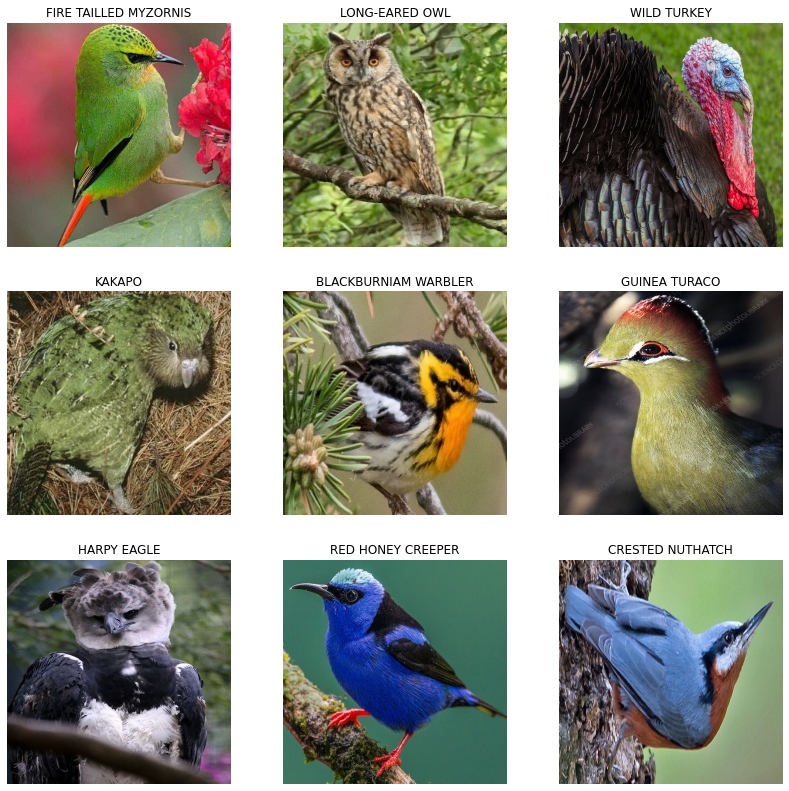

In [ ]:
num_classes=len(os.listdir('/root/train'))
fig, ax= plt.subplots(nrows=3, ncols=3, figsize=(14,14))
for i in range(3):
  for j in range(3):
    bird_species=os.listdir('/root/train')[random.randint(0,num_classes-1)]  # selecting a random dir of birds in the range of 0-9
    bird_dir=os.path.join('/root/train/'+bird_species)
    img_path=random.choice(os.listdir(bird_dir))
    rand_img=mpimg.imread(os.path.join(bird_dir+'/'+img_path))
    print(rand_img.shape)
    ax[i, j].imshow(rand_img)
    ax[i, j].set_title(bird_species)
    ax[i, j].axis('off')
    

  

# Working with Image Data Generators in Keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/255, horizontal_flip=True, shear_range=0.5, rotation_range=45,zoom_range=0.3)
test_datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
tot=0
for bird_species in os.listdir('/root/train/'):
  tot+=len(os.listdir(os.path.join('/root/train/'+ bird_species)))
print(f'Total training pics:-> {tot}')
tot=0
for bird_species in os.listdir('/root/test/'):
  tot+=len(os.listdir(os.path.join('/root/test/'+ bird_species)))
print(f'Total testing pics:-> {tot}')
tot=0
for bird_species in os.listdir('/root/valid/'):
  tot+=len(os.listdir(os.path.join('/root/valid/'+ bird_species)))
print(f'Total validation pics:-> {tot}')

Total training pics:-> 35215
Total testing pics:-> 1250
Total validation pics:-> 1250


In [ ]:
train_generator=train_datagen.flow_from_directory('/root/train', target_size=(224,224), class_mode='categorical',batch_size=128, shuffle=True, seed=43)
test_generator=test_datagen.flow_from_directory('/root/test/', target_size=(224,224), class_mode='categorical' )

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


**Note:**

* The present dataset has been updated to 265 Bird species on the Kaggle, this code works even for that!!
Due to this update all tuning related files won’t be of any use to share, hence one needs to run the whole code again :)

* New API token needs to be generated from Kaggle (if u want to use the dataset without downloading on your local PC)

* Link to the Dataset: https://www.kaggle.com/gpiosenka/100-bird-species/data

# Now time for tuning the hyperparameters of our basic CNN Model

In [ ]:
import numpy as np
np.geomspace(10e-1, 10e-5,5) # an example

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])

Some information on this section

* Hyperparameters: Hyperparameters are the variables which determines the network structure(In our case: Number of Hidden Units, dropout_rate,  filter size, no. of filters, etc) and the variables which determine how the network is trained(Eg: Learning Rate). These are set before training.

* Fine-tuning: In general, means making small adjustments to a process to achieve the desired output or performance.
Below is the Hyperparameter-tuning procedure for the basic CNN model, this process takes about 1.5 hours.


In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def create_model(hp):
  model=keras.Sequential()
  model.add(keras.layers.Conv2D(filters=hp.Int('filter1', min_value=16, max_value=64, step=16), kernel_size=hp.Choice('kernel',values=[3,5]), input_shape=(224,224,3), padding='same', activation='relu'))
  model.add(keras.layers.Conv2D(filters=hp.Int('filter2', min_value=16, max_value=64, step=16), kernel_size=(3,3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D(hp.Choice('size', [2,3])))
  model.add(keras.layers.Conv2D(filters=hp.Int('filter3', min_value=16, max_value=64, step=16), kernel_size=(3,3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(keras.layers.Conv2D(filters=hp.Int('filter3', min_value=16, max_value=64, step=16), kernel_size=(3,3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D(hp.Choice('size2', [2,3])))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1024, activation=hp.Choice('activation1', values=['relu','tanh'])))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(250, activation='softmax'))
  model.compile(optimizer=keras.optimizers.Adam(lr=hp.Choice('lr', list(np.geomspace(10e-1,10e-4,4))[1:])), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
tuner=kerastuner.tuners.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,
    # executions_per_trial=2,
    directory='/content/drive/MyDrive/Kaggle/',
    project_name='Birds_classifier'
)
tuner.search(train_generator, epochs=3, validation_data=test_generator)
# tuner.search(data, labels, epochs=3, validation_data=(valid_data,valid_labels))

Trial 4 Complete [00h 20m 09s]
val_accuracy: 0.2240000069141388

Best val_accuracy So Far: 0.2240000069141388
Total elapsed time: 01h 23m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# best_model=tuner.get_best_models(num_models=1)[0]
best_hp=tuner.get_best_hyperparameters()[0]
best_model_cnn = tuner.hypermodel.build(best_hp)
# best_model.summary()

In [ ]:
best_model_cnn.fit(train_generator, epochs=20,validation_data=test_generator, verbose=1)

In [ ]:
# !mkdir /content/drive/MyDrive/Kaggle/Birds_classifier
best_model_cnn.save('/content/drive/MyDrive/Kaggle/Birds_classifier/BirdsModel')  # in h5 format and can be loaded back by using models.load_model(path)

# ResNet architecture and its Hyperparameter tuning

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/255, horizontal_flip=True, shear_range=0.5, rotation_range=45,zoom_range=0.3)
test_datagen=ImageDataGenerator(rescale=1/255)
train_generator=train_datagen.flow_from_directory('/root/train', target_size=(224,224), class_mode='categorical', shuffle=True, seed=43)
test_generator=test_datagen.flow_from_directory('/root/test/', target_size=(224,224), class_mode='categorical' )

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [ ]:
from kerastuner.tuners import Hyperband
from kerastuner.applications import HyperResNet

In [ ]:
model=HyperResNet(input_shape=(224,224,3), classes=250)
tuner=Hyperband(model, 
              objective='val_accuracy',
              max_epochs=3,
              seed=3,
              directory='/content/drive/MyDrive/Kaggle/',
              project_name='ResNet_for_birds')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Kaggle/ResNet_for_birds/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Kaggle/ResNet_for_birds/tuner0.json


In [ ]:
tuner.search(train_generator,validation_data=test_generator)
best_model=tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Oracle triggered exit


In [ ]:
# best_model=keras.models.load_model('/content/drive/MyDrive/Kaggle/ResNet_for_birds/')
best_model.fit(train_generator,validation_data=test_generator, epochs=135, initial_epoch=130)

Epoch 131/135
1101/1101 [==============================] - 650s 575ms/step - loss: 0.2202 - accuracy: 0.9503 - val_loss: 9.8910 - val_accuracy: 0.9288
Epoch 132/135
1101/1101 [==============================] - 633s 575ms/step - loss: 0.2183 - accuracy: 0.9513 - val_loss: 12.6462 - val_accuracy: 0.9040
Epoch 133/135
1101/1101 [==============================] - 634s 575ms/step - loss: 0.2209 - accuracy: 0.9495 - val_loss: 17.5544 - val_accuracy: 0.9136
Epoch 134/135
1101/1101 [==============================] - 634s 576ms/step - loss: 0.2175 - accuracy: 0.9516 - val_loss: 4.7247 - val_accuracy: 0.9320
Epoch 135/135
1101/1101 [==============================] - 634s 576ms/step - loss: 0.2342 - accuracy: 0.9516 - val_loss: 121.8835 - val_accuracy: 0.8024


In [ ]:
best_model.save('/content/drive/MyDrive/Kaggle/ResNet_for_birds/resnet_model.h5')
best_model.save('/content/drive/MyDrive/Kaggle/ResNet_for_birds/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Kaggle/ResNet_for_birds/assets


# Additional Implementation (Useful for deployment of the model)

*Here we go with the Tensorflow lite architecture for further understanding of deploying the model on the mobile*


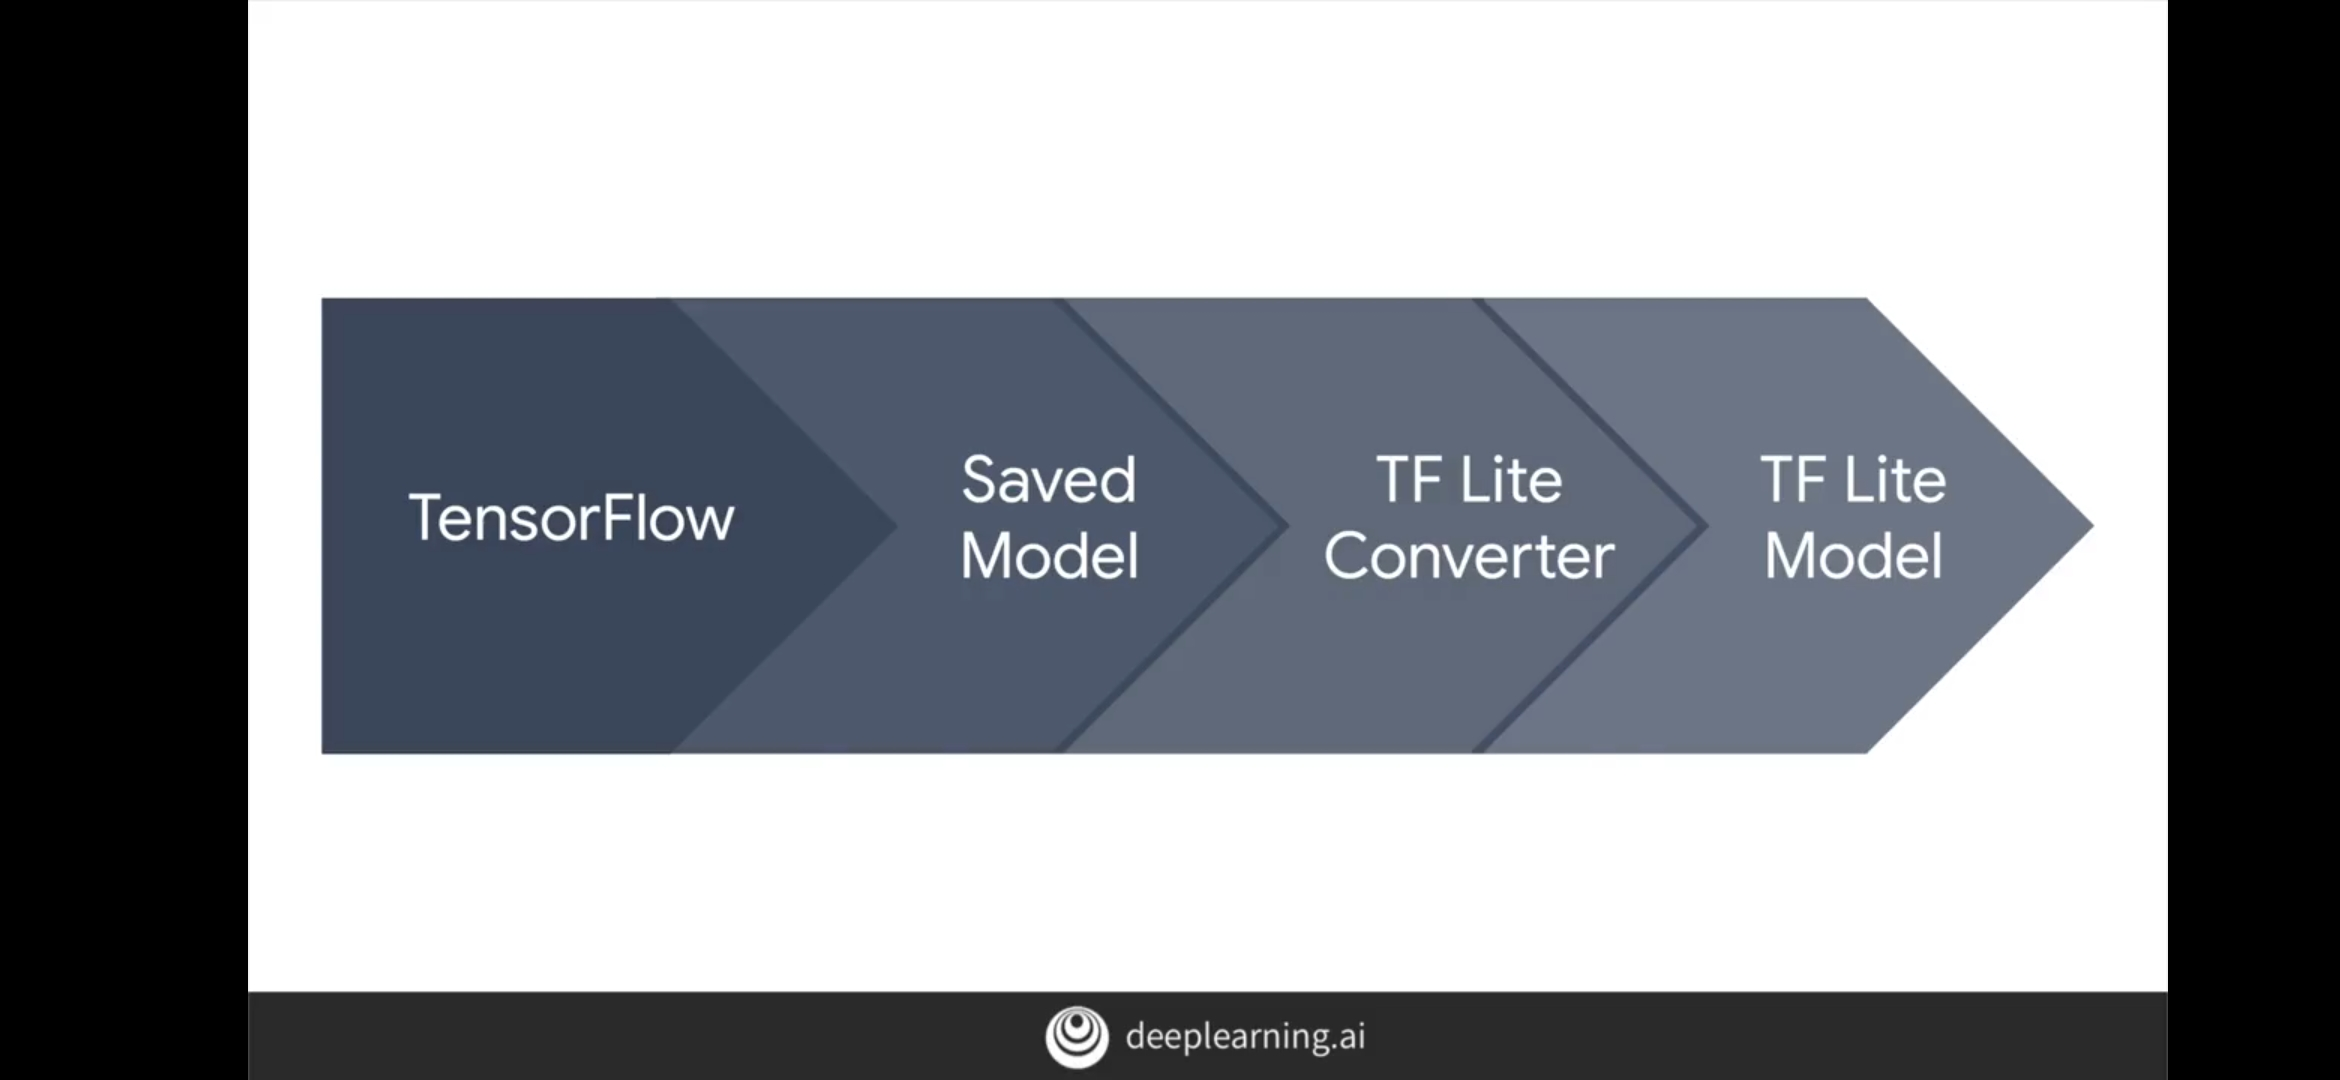

**Pic credits: deeplearning.ai**

In [ ]:
# import pathlib
# convert the model
converter=tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model= converter.convert()

# save the model
# tflite_model_file=pathlib.Path('path/to/save/model')
# tflite_model_file.write_bytes(tflite_model)
  # or
open('/content/drive/MyDrive/Kaggle/ResNet_for_birds/resnet-model.tflite' , 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphw9pmvnj/assets


171924256

In [ ]:
interpreter=tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input=interpreter.get_input_details()
output=interpreter.get_output_details()
input_shape=input[0]['shape']
i,o=[],[]


In [ ]:
#model=keras.models.load_model('/content/drive/MyDrive/Kaggle/Birds_classifier/BirdsModel')
# for TFLite mobile version conversion procedure
# with keras save func
'''
   model.save('modelname.h5')
   # convert the model
      converter=tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model= converter.convert()

   # save the model
      tflite_model_file=pathlib.Path('path/to/save/model')
      tflite_model_file.write_bytes(tflite_model)
      or
      open('model.tflite' , 'wb').write(tflite_model)

'''


# with tf saved_model
'''
   (import pathlib) first
   # export the savemodel
      export_dir='path/to/location'
      tf.saved_model.save(model1,export_dir)
   # convert the model
      converter=tf.lite.TFLiteConverter.from_saved_model(export_dir)
      tflite_model= converter.convert()
   # save the model
      tflite_model_file=pathlib.Path('path/to/save/model')
      tflite_model_file.write_bytes(tflite_model)

  That's it :)
'''

***Quantization is a technique which reduces the precision and model size to work better on mobile***

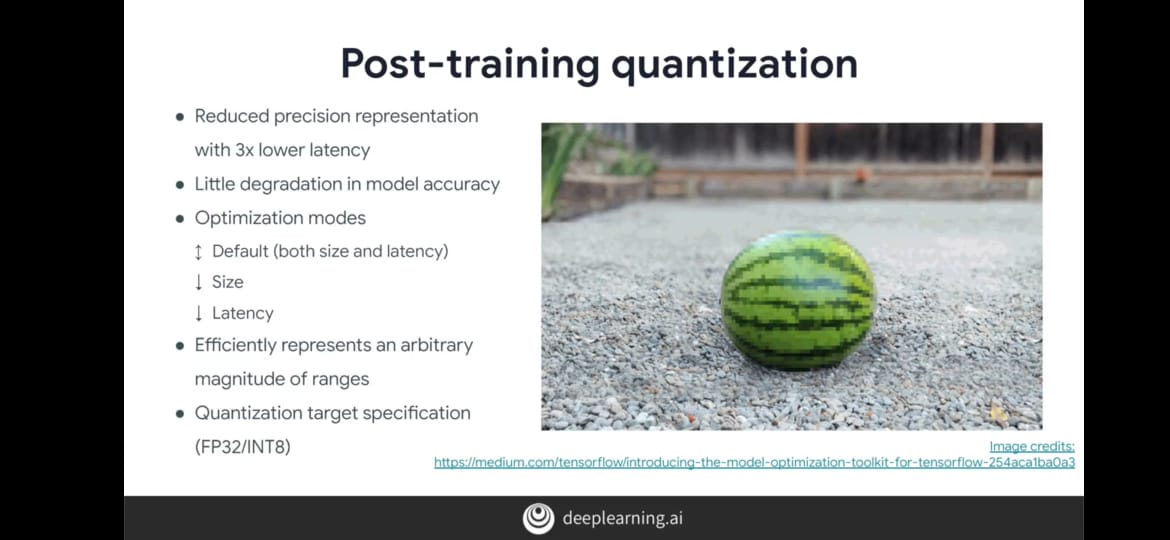